In [1]:
import os
import pandas as pd

# Dataset base path
base_path = "/kaggle/input/stock-market-dataset"

# Paths to folders and files
stocks_path = os.path.join(base_path, "stocks")
etfs_path = os.path.join(base_path, "etfs")
meta_path = os.path.join(base_path, "symbols_valid_meta.csv")

# Load metadata
meta_df = pd.read_csv(meta_path)
print("Metadata sample:")
print(meta_df.head())

# Number of stocks and ETFs
stock_files = os.listdir(stocks_path)
etf_files = os.listdir(etfs_path)
print(f"\nNumber of stocks: {len(stock_files)}")
print(f"Number of ETFs: {len(etf_files)}")

# Explore a sample stock CSV
sample_stock = pd.read_csv(os.path.join(stocks_path, stock_files[0]))
print(f"\nSample stock file: {stock_files[0]}")
print(sample_stock.head())

# Assign to df and ensure 'Date' column exists
df = sample_stock.copy()

# Convert 'Date' to datetime if not already
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])  # Drop rows where Date couldn't be parsed


# Explore a sample ETF CSV
sample_etf = pd.read_csv(os.path.join(etfs_path, etf_files[0]))
print(f"\nSample ETF file: {etf_files[0]}")
print(sample_etf.head())

# Filter metadata (optional filtering logic)
# Example: Only active stocks on NASDAQ and not ETFs
filtered_meta = meta_df[
    (meta_df['Listing Exchange'] == 'N') & 
    (meta_df['ETF'] == 'N') & 
    (meta_df['Test Issue'] == 'N')
]
print(f"\nFiltered metadata: {filtered_meta.shape[0]} entries")
print(filtered_meta.head())


Metadata sample:
  Nasdaq Traded Symbol                                      Security Name  \
0             Y      A            Agilent Technologies, Inc. Common Stock   
1             Y     AA                    Alcoa Corporation Common Stock    
2             Y   AAAU                       Perth Mint Physical Gold ETF   
3             Y   AACG  ATA Creativity Global - American Depositary Sh...   
4             Y   AADR                AdvisorShares Dorsey Wright ADR ETF   

  Listing Exchange Market Category ETF  Round Lot Size Test Issue  \
0                N                   N           100.0          N   
1                N                   N           100.0          N   
2                P                   Y           100.0          N   
3                Q               G   N           100.0          N   
4                P                   Y           100.0          N   

  Financial Status CQS Symbol NASDAQ Symbol NextShares  
0              NaN          A             A     


Loaded data for: AAPL

Missing values:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Duplicate rows: 0


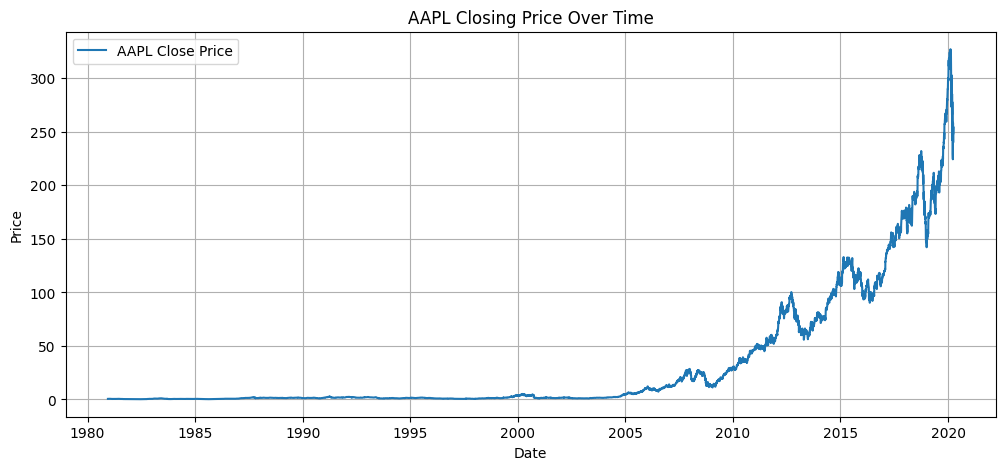

In [2]:
import matplotlib.pyplot as plt

# Example: Pick a stock from filtered metadata (e.g., Apple)
target_symbol = "AAPL"
target_file = f"{target_symbol}.csv"

# Confirm it's in the stocks directory
if target_file in stock_files:
    df = pd.read_csv(os.path.join(stocks_path, target_file))
    print(f"\nLoaded data for: {target_symbol}")
else:
    raise FileNotFoundError(f"{target_symbol} not found in stocks folder")

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Check for duplicates
print("\nDuplicate rows:", df.duplicated().sum())

# Basic plot of the closing price
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label=f'{target_symbol} Close Price')
plt.title(f'{target_symbol} Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()


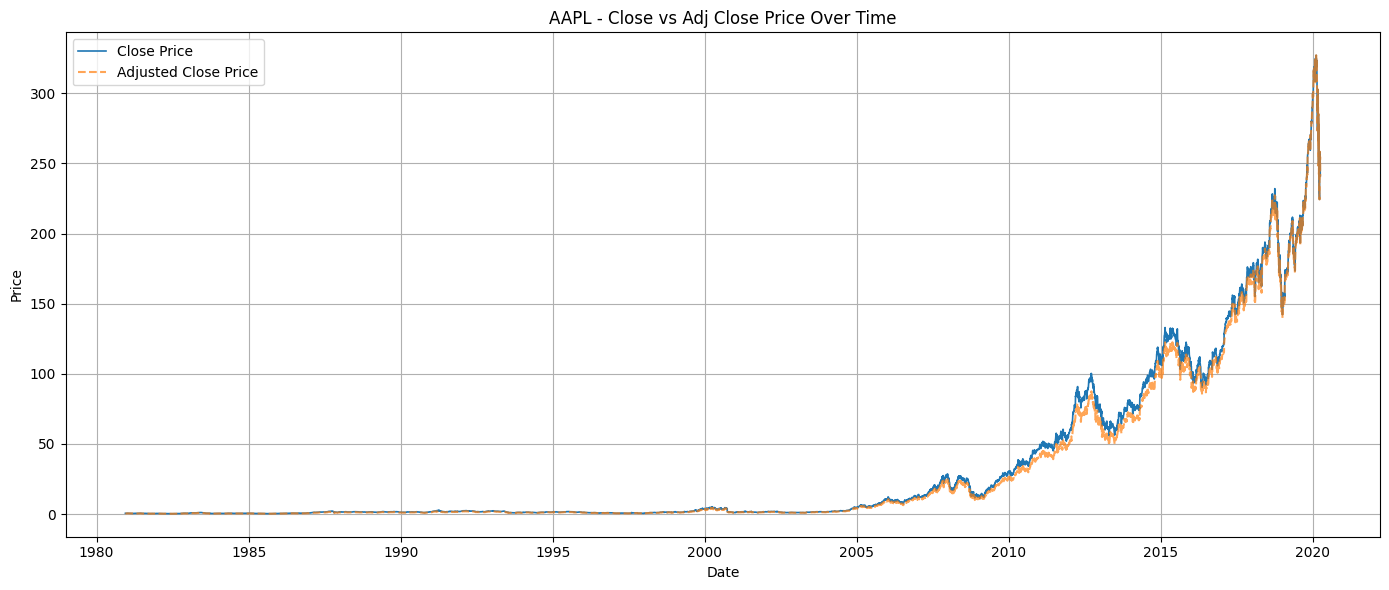

In [3]:
import matplotlib.pyplot as plt

# Plot Close and Adj Close
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.2)
plt.plot(df['Adj Close'], label='Adjusted Close Price', linestyle='--', alpha=0.7)
plt.title(f'{target_symbol} - Close vs Adj Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_455/952511789.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


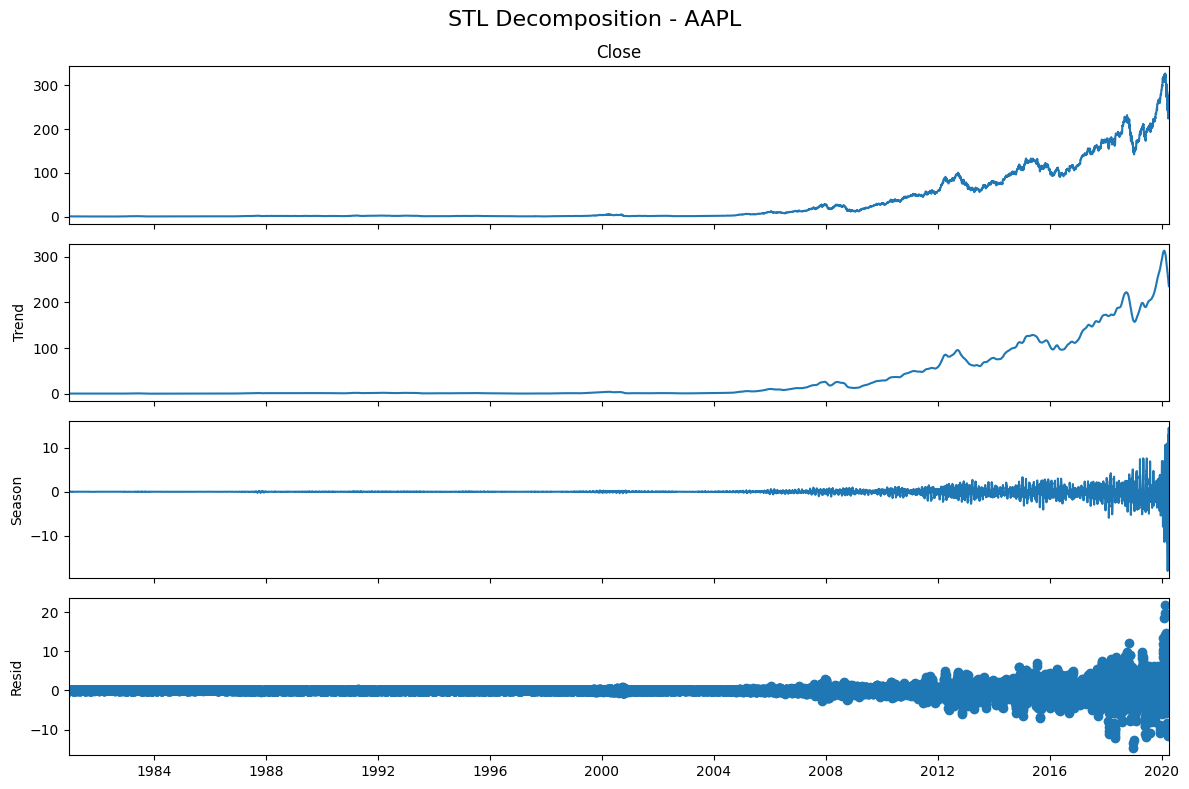

In [4]:
from statsmodels.tsa.seasonal import STL

# Perform STL Decomposition (use weekly frequency if daily is too noisy)
stl = STL(df['Close'], period=30)  # You can change period based on data (e.g., 30 for monthly)
result = stl.fit()

# Plot the decomposed components
fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle(f'STL Decomposition - {target_symbol}', fontsize=16)
plt.tight_layout()
plt.show()


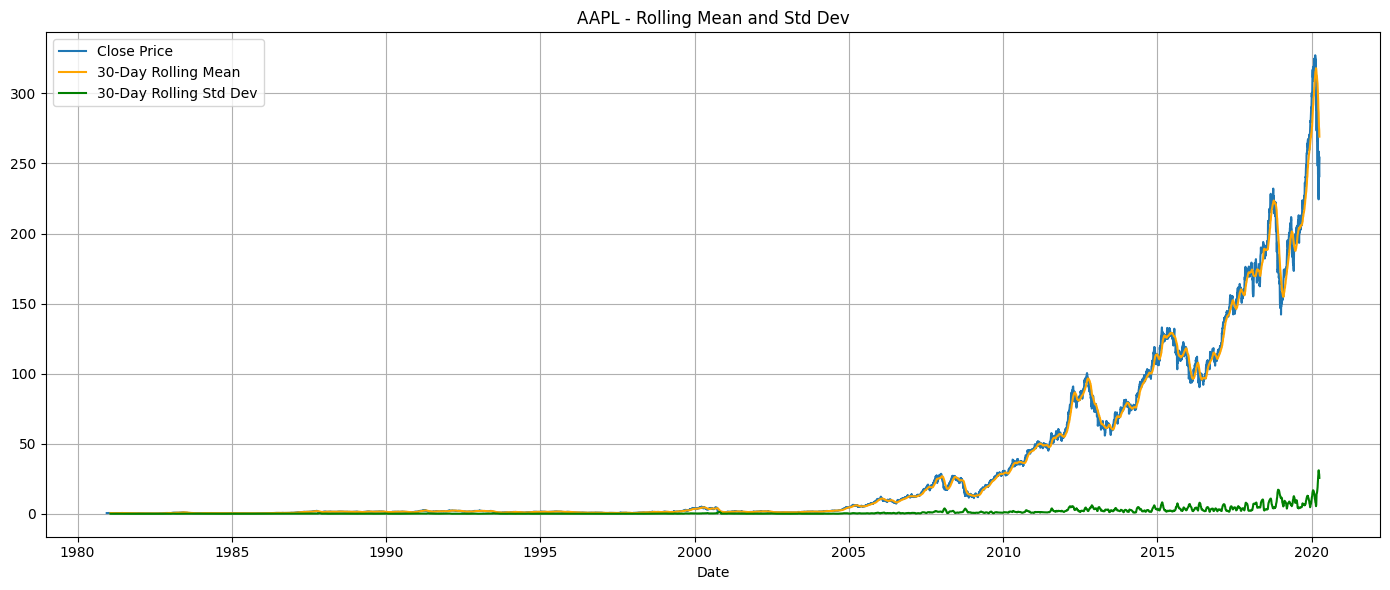

In [5]:
# Rolling mean and standard deviation
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='orange')
plt.plot(rolling_std, label='30-Day Rolling Std Dev', color='green')
plt.title(f'{target_symbol} - Rolling Mean and Std Dev')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Close'])
print("\nAugmented Dickey-Fuller (ADF) Test:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')



Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: 1.8939738468260838
p-value: 0.9985182618845982
Critical Value (1%): -3.4310126482982626
Critical Value (5%): -2.861832850708558
Critical Value (10%): -2.5669258793000673


In [7]:
from statsmodels.tsa.stattools import kpss

kpss_result = kpss(df['Close'], regression='c')
print("\nKPSS Test:")
print(f"KPSS Statistic: {kpss_result[0]}")
print(f"p-value: {kpss_result[1]}")
for key, value in kpss_result[3].items():
    print(f'Critical Value ({key}): {value}')



KPSS Test:
KPSS Statistic: 9.751028668753257
p-value: 0.01
Critical Value (10%): 0.347
Critical Value (5%): 0.463
Critical Value (2.5%): 0.574
Critical Value (1%): 0.739


/tmp/ipykernel_455/1936183123.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['Close'], regression='c')


In [8]:
df['Close_diff1'] = df['Close'].diff()
# ADF test on differenced series
adf_result = adfuller(df['Close_diff1'].dropna())
print(f"ADF p-value (1st diff): {adf_result[1]}")

# KPSS test on differenced series
kpss_result = kpss(df['Close_diff1'].dropna(), regression='c')
print(f"KPSS p-value (1st diff): {kpss_result[1]}")


ADF p-value (1st diff): 3.673144669578939e-28
KPSS p-value (1st diff): 0.036947733647833325


In [9]:
# Second-order differencing
df['Close_diff2'] = df['Close_diff1'].diff()

# ADF Test
from statsmodels.tsa.stattools import adfuller, kpss

adf_result_2 = adfuller(df['Close_diff2'].dropna())
print("\nADF Test on 2nd Order Difference:")
print(f"ADF Statistic: {adf_result_2[0]}")
print(f"p-value: {adf_result_2[1]}")

# KPSS Test
kpss_result_2 = kpss(df['Close_diff2'].dropna(), regression='c')
print("\nKPSS Test on 2nd Order Difference:")
print(f"KPSS Statistic: {kpss_result_2[0]}")
print(f"p-value: {kpss_result_2[1]}")



ADF Test on 2nd Order Difference:
ADF Statistic: -24.06906088729294
p-value: 0.0

KPSS Test on 2nd Order Difference:
KPSS Statistic: 0.09310194133604181
p-value: 0.1


/tmp/ipykernel_455/3599505674.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result_2 = kpss(df['Close_diff2'].dropna(), regression='c')


In [10]:

# Drop NA values (introduced due to differencing)
df = df.dropna(subset=['Close_diff2'])

# Train/test split (last 365 days as test)
split_date = df.index[-365]
train = df.loc[df.index < split_date, 'Close_diff2']
test = df.loc[df.index >= split_date, 'Close_diff2']

print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (9542,), Test shape: (365,)


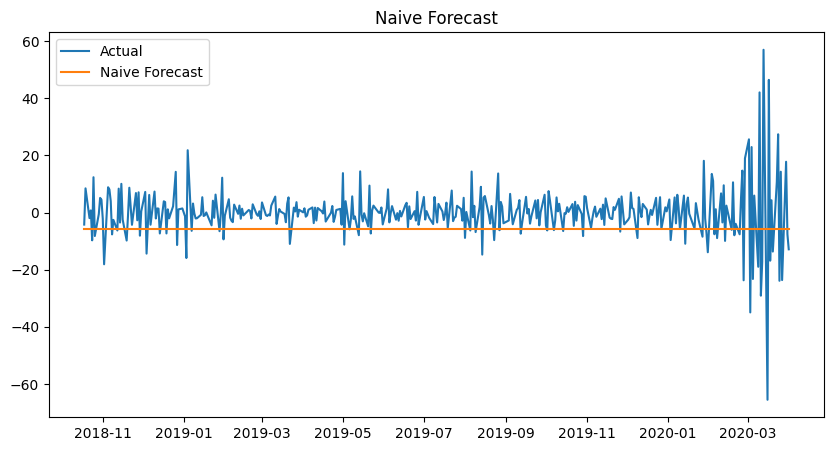

Naive MSE: 115.7383, MAE: 7.7636


In [11]:
# Naive forecast: last value from train
naive_forecast = [train.iloc[-1]] * len(test)

# Plot
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, naive_forecast, label="Naive Forecast")
plt.legend()
plt.title("Naive Forecast")
plt.show()

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

naive_mse = mean_squared_error(test, naive_forecast)
naive_mae = mean_absolute_error(test, naive_forecast)

print(f"Naive MSE: {naive_mse:.4f}, MAE: {naive_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/pyth

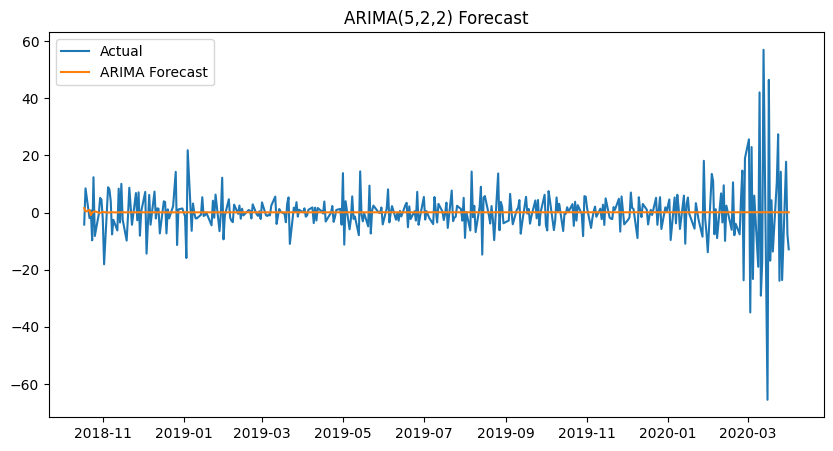

ARIMA(5,2,2) MSE: 83.1558, MAE: 5.4985
AIC: 25216.24, BIC: 25273.55


In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train, order=(5,2,2))
arima_result = arima_model.fit()

# Forecast
forecast_arima = arima_result.forecast(steps=len(test))

# Plot
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast_arima, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA(5,2,2) Forecast")
plt.show()

# Evaluate
arima_mse = mean_squared_error(test, forecast_arima)
arima_mae = mean_absolute_error(test, forecast_arima)

print(f"ARIMA(5,2,2) MSE: {arima_mse:.4f}, MAE: {arima_mae:.4f}")
print(f"AIC: {arima_result.aic:.2f}, BIC: {arima_result.bic:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-pack

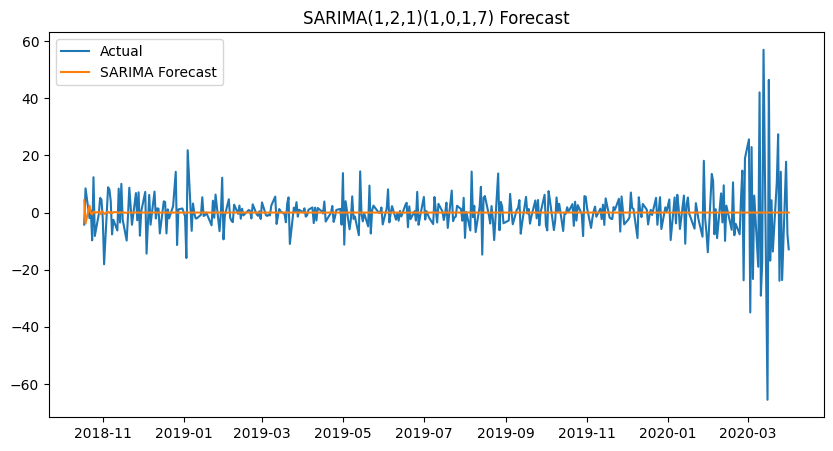

SARIMA MSE: 83.3603, MAE: 5.5123
AIC: 33569.73, BIC: 33605.55


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1,2,1), seasonal_order=(1,0,1,7))
sarima_result = sarima_model.fit(disp=False)

# Forecast
forecast_sarima = sarima_result.forecast(steps=len(test))

# Plot
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast_sarima, label="SARIMA Forecast")
plt.legend()
plt.title("SARIMA(1,2,1)(1,0,1,7) Forecast")
plt.show()

# Evaluate
sarima_mse = mean_squared_error(test, forecast_sarima)
sarima_mae = mean_absolute_error(test, forecast_sarima)

print(f"SARIMA MSE: {sarima_mse:.4f}, MAE: {sarima_mae:.4f}")
print(f"AIC: {sarima_result.aic:.2f}, BIC: {sarima_result.bic:.2f}")


In [14]:
summary_df = pd.DataFrame({
    'Model': ['Naive', 'ARIMA(5,2,2)', 'SARIMA(1,2,1)(1,0,1,7)'],
    'MSE': [naive_mse, arima_mse, sarima_mse],
    'MAE': [naive_mae, arima_mae, sarima_mae],
    'AIC': [None, arima_result.aic, sarima_result.aic],
    'BIC': [None, arima_result.bic, sarima_result.bic]
})

print("\nModel Performance Summary:")
print(summary_df)


Model Performance Summary:
                    Model         MSE       MAE           AIC           BIC
0                   Naive  115.738311  7.763578           NaN           NaN
1            ARIMA(5,2,2)   83.155757  5.498516  25216.242363  25273.548353
2  SARIMA(1,2,1)(1,0,1,7)   83.360252  5.512264  33569.728843  33605.545087


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [15]:
# Install Prophet if not already installed (Kaggle usually has it pre-installed)
!pip install --quiet prophet

from prophet import Prophet


In [16]:
# Create a new DataFrame for Prophet using original 'Close'
prophet_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Drop NA just in case
prophet_df.dropna(inplace=True)

# Train/test split (365 days as test)
split_date = prophet_df['ds'].iloc[-365]
train_prophet = prophet_df[prophet_df['ds'] < split_date]
test_prophet = prophet_df[prophet_df['ds'] >= split_date]


In [17]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(train_prophet)


07:43:28 - cmdstanpy - INFO - Chain [1] start processing
07:43:30 - cmdstanpy - INFO - Chain [1] done processing


/tmp/ipykernel_455/1907650578.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


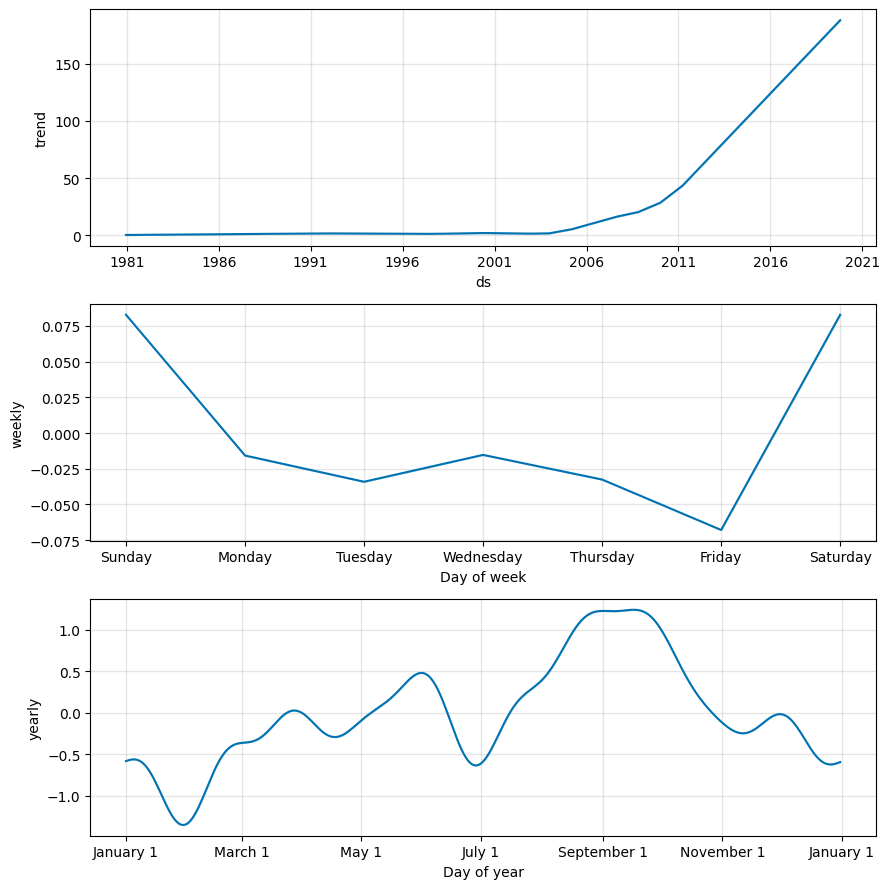

In [18]:
# Create future DataFrame for prediction
future = model.make_future_dataframe(periods=len(test_prophet))

# Make forecast
forecast = model.predict(future)

# View forecast components
model.plot_components(forecast)
plt.tight_layout()
plt.show()


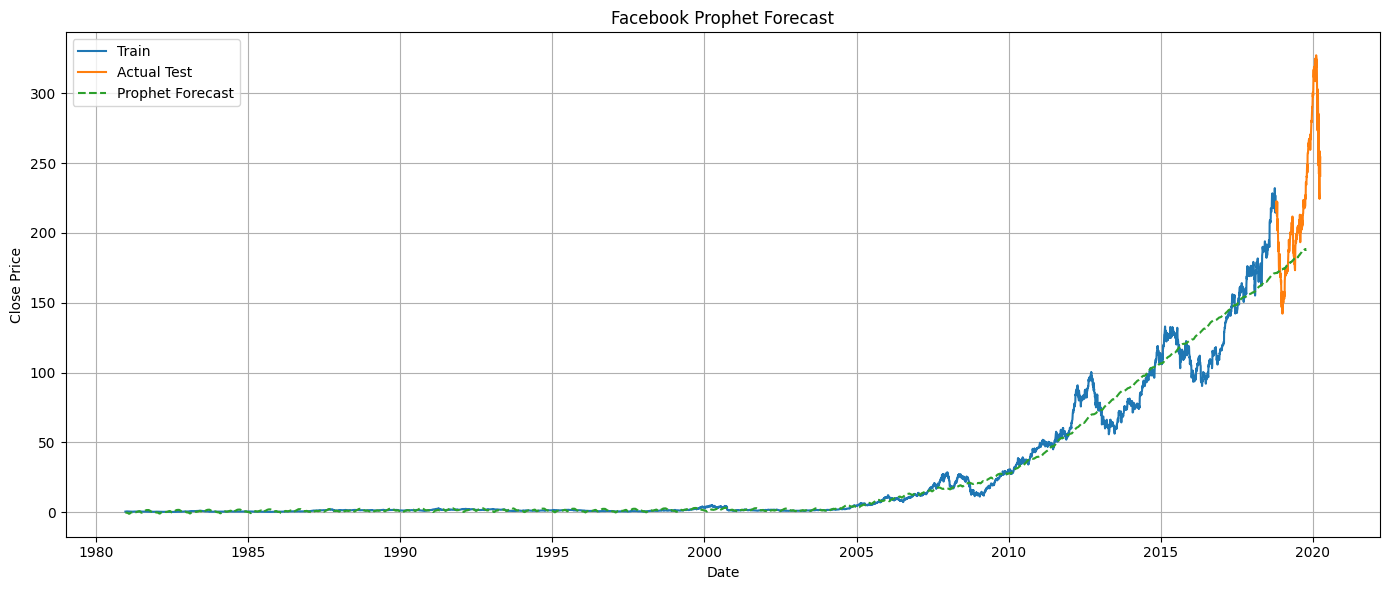

In [19]:
# Merge forecast with actual test data
forecast_merge = forecast[['ds', 'yhat']].set_index('ds').join(test_prophet.set_index('ds'))

# Define prophet_pred and y_test for consistent naming
prophet_pred = forecast_merge['yhat']
y_test = forecast_merge['y']

# Plot
plt.figure(figsize=(14, 6))
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train')
plt.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test')
plt.plot(forecast_merge.index, forecast_merge['yhat'], label='Prophet Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Facebook Prophet Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Drop NA if present in merged forecast
forecast_merge.dropna(inplace=True)

prophet_mse = mean_squared_error(forecast_merge['y'], forecast_merge['yhat'])
prophet_mae = mean_absolute_error(forecast_merge['y'], forecast_merge['yhat'])

print(f"Prophet MSE: {prophet_mse:.4f}")
print(f"Prophet MAE: {prophet_mae:.4f}")


Prophet MSE: 505.8583
Prophet MAE: 18.8204


In [21]:
# Extend the summary with Prophet results
summary_df = pd.DataFrame({
    'Model': ['Naive', 'ARIMA(5,2,2)', 'SARIMA(1,2,1)(1,0,1,7)', 'Prophet'],
    'MSE': [naive_mse, arima_mse, sarima_mse, prophet_mse],
    'MAE': [naive_mae, arima_mae, sarima_mae, prophet_mae],
    'AIC': [None, arima_result.aic, sarima_result.aic, None],
    'BIC': [None, arima_result.bic, sarima_result.bic, None]
})

# Display final summary
print("\nModel Performance Summary:")
print(summary_df)



Model Performance Summary:
                    Model         MSE        MAE           AIC           BIC
0                   Naive  115.738311   7.763578           NaN           NaN
1            ARIMA(5,2,2)   83.155757   5.498516  25216.242363  25273.548353
2  SARIMA(1,2,1)(1,0,1,7)   83.360252   5.512264  33569.728843  33605.545087
3                 Prophet  505.858263  18.820387           NaN           NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [22]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use the Close_diff2 column
series = df['Close_diff2'].values.reshape(-1, 1)

# Normalize the series to [0, 1]
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(series)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Past 30 days to predict the next
X_all, y_all = create_sequences(scaled_series, sequence_length)

print("Input shape:", X_all.shape)  # (samples, sequence_length, 1)
print("Target shape:", y_all.shape)


Input shape: (9877, 30, 1)
Target shape: (9877, 1)


In [23]:
# Align to match the length after sequencing
split_index = len(df) - 365 - sequence_length

X_train = X_all[:split_index]
y_train = y_all[:split_index]
X_test = X_all[split_index:]
y_test = y_all[split_index:]

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Train samples: 9512
Test samples: 365


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build the model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


2025-07-17 07:43:33.819649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752738213.837172     455 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752738213.843910     455 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1752738216.966639     455 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752738216.967426     455 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1752738221.940280     517 service.cc:148] XLA service 0x7f742c00d230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752738221.940322     517 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752738221.940327     517 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752738222.394326     517 cuda_dnn.cc:529] Loaded cuDNN version 90300


 25/268 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2476

I0000 00:00:1752738224.530296     517 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0642 - val_loss: 5.7796e-04
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0061 - val_loss: 6.7673e-04
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039 - val_loss: 5.3417e-04
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0030 - val_loss: 5.5187e-04
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0022 - val_loss: 5.2849e-04
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0015 - val_loss: 5.2755e-04
Epoch 8/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - val_loss: 5.3305e-04
Epoch 9/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.9778e-04 - val_loss: 5.4582e-04
Epoch 10/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.8660e-04 - val_loss: 5.2612e-04
Epoch 11/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.8104e-04 - val_loss: 5.2744e-04
Epoch 12/

In [25]:
# Predict
y_pred_scaled = model.predict(X_test)

# Inverse transform to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred_scaled)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error

lstm_mse = mean_squared_error(y_test_actual, y_pred_actual)
lstm_mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
LSTM MSE: 83.2355
LSTM MAE: 5.4921


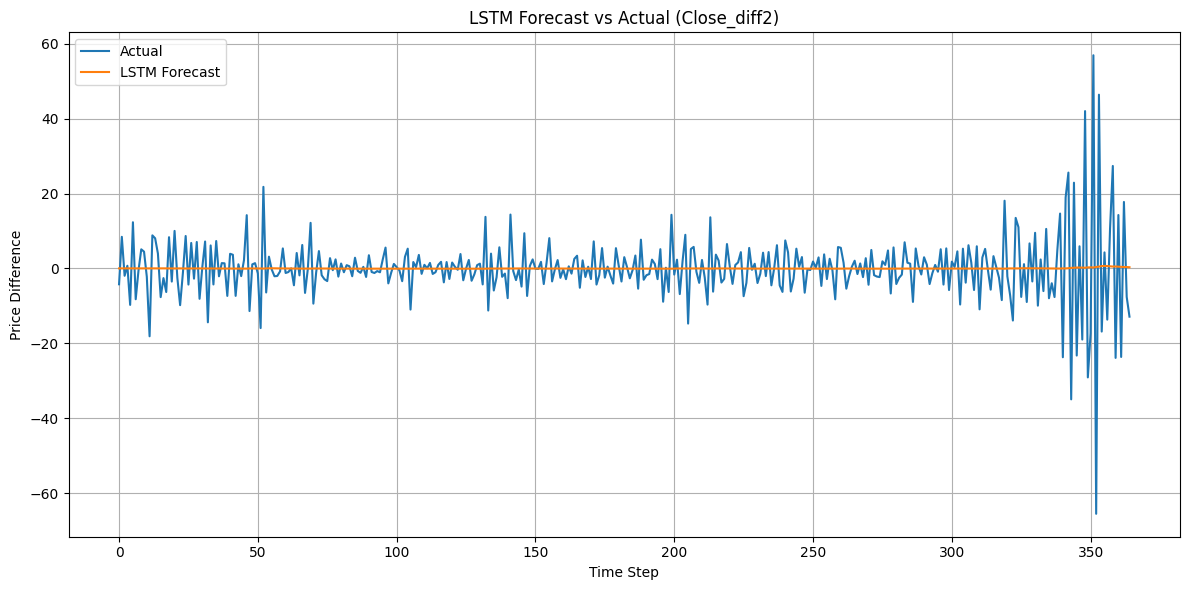

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='LSTM Forecast')
plt.title("LSTM Forecast vs Actual (Close_diff2)")
plt.xlabel("Time Step")
plt.ylabel("Price Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
summary_df.loc[len(summary_df)] = ['LSTM', lstm_mse, lstm_mae, None, None]
print("\nUpdated Model Performance Summary:")
print(summary_df)



Updated Model Performance Summary:
                    Model         MSE        MAE           AIC           BIC
0                   Naive  115.738311   7.763578           NaN           NaN
1            ARIMA(5,2,2)   83.155757   5.498516  25216.242363  25273.548353
2  SARIMA(1,2,1)(1,0,1,7)   83.360252   5.512264  33569.728843  33605.545087
3                 Prophet  505.858263  18.820387           NaN           NaN
4                    LSTM   83.235476   5.492099           NaN           NaN


/tmp/ipykernel_455/1809938003.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df.loc[len(summary_df)] = ['LSTM', lstm_mse, lstm_mae, None, None]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [32]:
print(forecast_merge.columns)
print(forecast_merge.head())


Index(['yhat', 'y'], dtype='object')
                  yhat           y
ds                                
2018-10-18  171.243620  216.020004
2018-10-19  171.219324  219.309998
2018-10-22  171.313350  220.649994
2018-10-23  171.311547  222.729996
2018-10-24  171.348051  215.089996


In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Metrics ===
def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calc_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Align Prophet predictions and true values
aligned_dates = df.index[-365:]
y_test_series = pd.Series(y_test.flatten(), index=aligned_dates)

# Reindex Prophet predictions to match y_test_series
prophet_aligned = forecast_merge.reindex(aligned_dates)['yhat']

# Drop NaNs from Prophet predictions and align y_test accordingly
valid_mask = prophet_aligned.notna()
prophet_aligned = prophet_aligned[valid_mask]
y_test_series = y_test_series[valid_mask]

# Prophet evaluation
prophet_mae = mean_absolute_error(y_test_series, prophet_aligned)
prophet_mse = calc_mse(y_test_series, prophet_aligned)
prophet_rmse = calc_rmse(y_test_series, prophet_aligned)

# ARIMA
arima_mae = mean_absolute_error(test, forecast_arima)
arima_mse = calc_mse(test, forecast_arima)
arima_rmse = calc_rmse(test, forecast_arima)

# SARIMA
sarima_mae = mean_absolute_error(test, forecast_sarima)
sarima_mse = calc_mse(test, forecast_sarima)
sarima_rmse = calc_rmse(test, forecast_sarima)

# LSTM
lstm_mae = mean_absolute_error(y_test_actual, y_pred_actual)
lstm_mse = calc_mse(y_test_actual, y_pred_actual)
lstm_rmse = calc_rmse(y_test_actual, y_pred_actual)

# Naive
naive_mae = mean_absolute_error(test, naive_forecast)
naive_mse = calc_mse(test, naive_forecast)
naive_rmse = calc_rmse(test, naive_forecast)

# === Summary Table ===
eval_summary = pd.DataFrame({
    'Model': ['Naive', 'ARIMA(5,2,2)', 'SARIMA(1,2,1)(1,0,1,7)', 'Prophet', 'LSTM'],
    'MSE': [naive_mse, arima_mse, sarima_mse, prophet_mse, lstm_mse],
    'MAE': [naive_mae, arima_mae, sarima_mae, prophet_mae, lstm_mae],
    'RMSE': [naive_rmse, arima_rmse, sarima_rmse, prophet_rmse, lstm_rmse]
})

print("\nModel Evaluation Summary:")
print(eval_summary.sort_values("RMSE"))



Model Evaluation Summary:
                    Model           MSE         MAE        RMSE
1            ARIMA(5,2,2)     83.155757    5.498516    9.118978
4                    LSTM     83.235476    5.492099    9.123348
2  SARIMA(1,2,1)(1,0,1,7)     83.360252    5.512264    9.130184
0                   Naive    115.738311    7.763578   10.758174
3                 Prophet  32046.524492  178.936098  179.015431


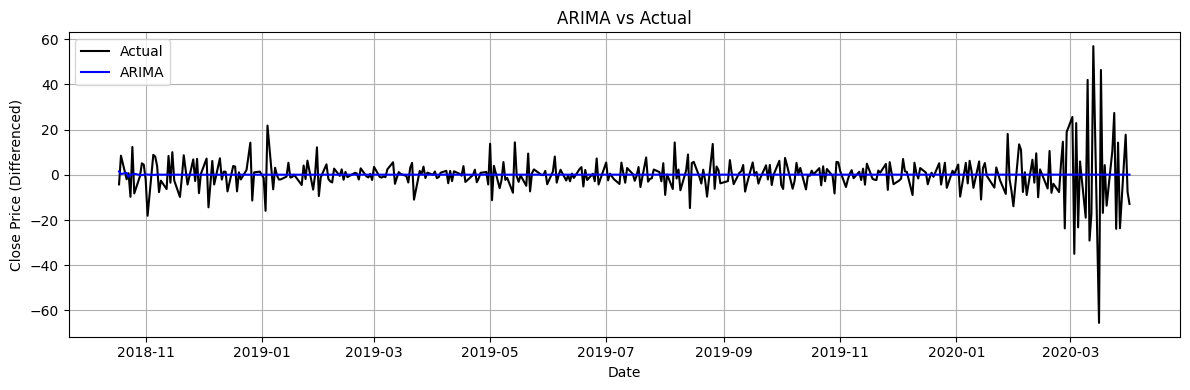

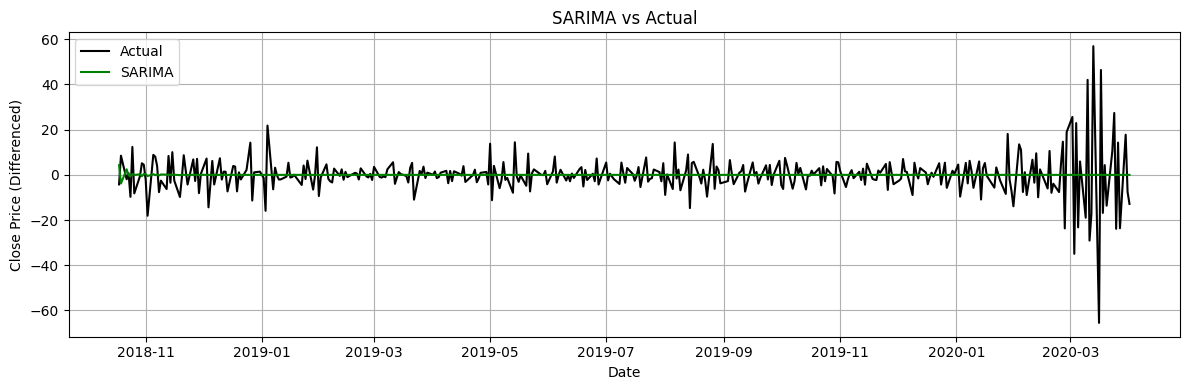

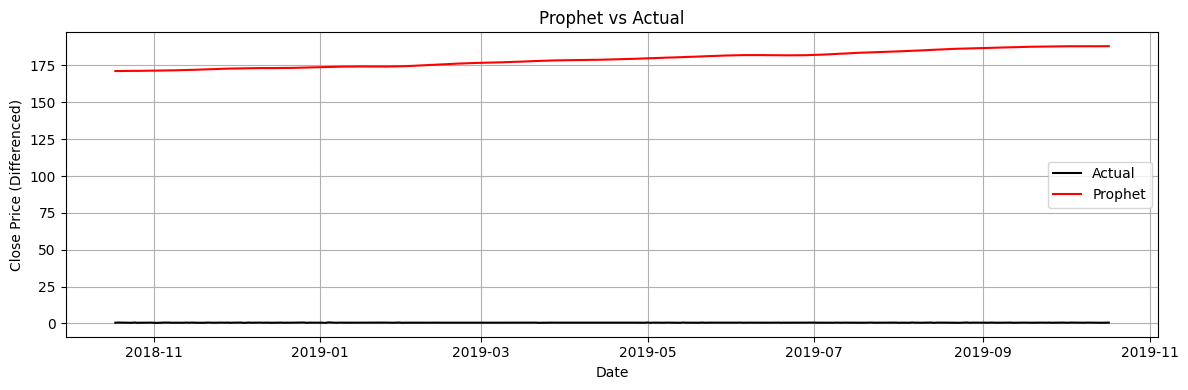

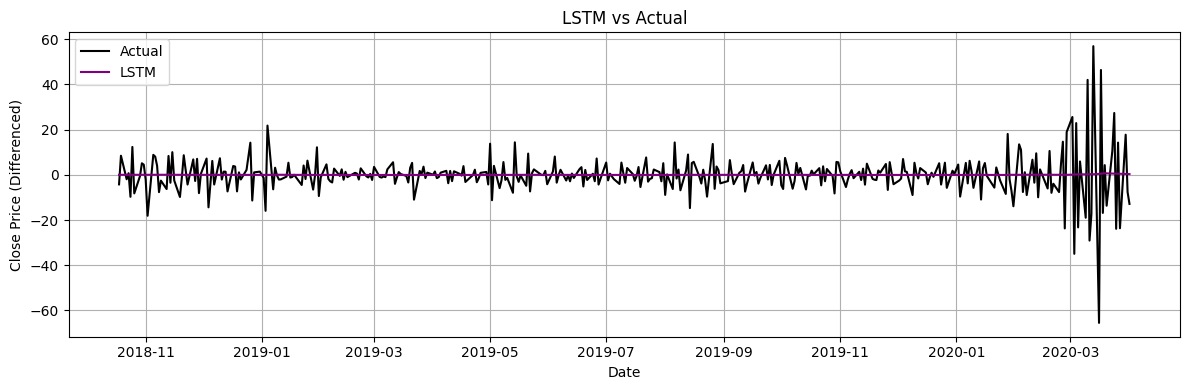

In [47]:
import matplotlib.pyplot as plt

# Plot: ARIMA vs Actual
plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label="Actual", color='black')
plt.plot(test.index, forecast_arima, label="ARIMA", color='blue')
plt.title("ARIMA vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price (Differenced)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: SARIMA vs Actual
plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label="Actual", color='black')
plt.plot(test.index, forecast_sarima, label="SARIMA", color='green')
plt.title("SARIMA vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price (Differenced)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Prophet vs Actual
plt.figure(figsize=(12, 4))
plt.plot(y_test_series.index, y_test_series, label="Actual", color='black')
plt.plot(y_test_series.index, prophet_aligned, label="Prophet", color='red')
plt.title("Prophet vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price (Differenced)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: LSTM vs Actual
plt.figure(figsize=(12, 4))
plt.plot(test.index, test, label="Actual", color='black')
plt.plot(test.index, y_pred_actual, label="LSTM", color='purple')
plt.title("LSTM vs Actual")
plt.xlabel("Date")
plt.ylabel("Close Price (Differenced)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


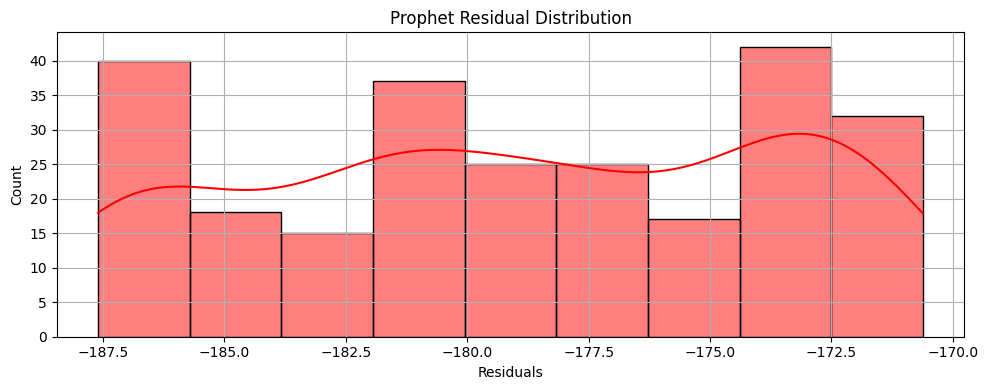

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


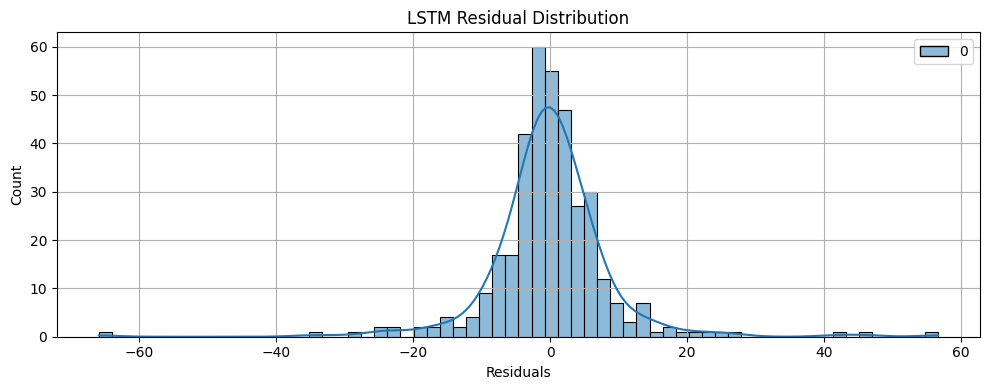

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# === Prophet Residuals ===
plt.figure(figsize=(10, 4))
sns.histplot(residuals_prophet, kde=True, color='red')
plt.title("Prophet Residual Distribution")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()

# === LSTM Residuals ===
plt.figure(figsize=(10, 4))
sns.histplot(residuals_lstm, kde=True, color='purple')
plt.title("LSTM Residual Distribution")
plt.xlabel("Residuals")
plt.grid(True)
plt.tight_layout()
plt.show()
